# BP神经网络预测

这里根据师姐的论文和matlab代码，利用python重写了一下，简单的建立一个三层的神经网络，即除却输入层和输出层就只用一层隐藏层

In [1]:
# 导入包
import torch
from torch import nn
import numpy as np
import torch.nn.functional as Fun
import scipy.io as scio
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

## 读取数据

数据是提取师姐处理后的血糖数据，数据量较小，仅有200多个数据

* `ppp`是用于预测的特征，分别为*收缩压*、*脉率(心率)*、*(体温)*、*吸光度*
* `TTT`即对应特征的血糖值

In [2]:
file_name = "data.mat"
data = scio.loadmat(file_name)
# PPP标签的是用于预测血糖的四个特征，作为features
x = data.get("PPP")
x = x.T
# TTT标签是血糖数据，作为labels
y = data.get("TTT")
y = y[0].reshape(len(y[0]),1)

In [3]:
print("x.shape :", x.shape, " y.shape: ", y.shape)

x.shape : (205, 4)  y.shape:  (205, 1)


确保`x`和`y`的第一维的维度相同，且`y.shape`为`(205, 1)`而不是`(205, )`

分别查看`x`和`y`的部分数据

In [4]:
print(x[0:5])

[[ 9.53333333e+01  7.73333333e+01  3.67333333e+01 -7.13518730e-01]
 [ 1.04333333e+02  5.80000000e+01  3.32000000e+01 -6.43337135e-01]
 [ 9.50000000e+01  7.30000000e+01  3.55000000e+01  9.59860109e-02]
 [ 9.40000000e+01  7.10000000e+01  3.51000000e+01  3.01645487e-01]
 [ 1.03000000e+02  6.73333333e+01  3.64666667e+01 -4.38108606e-02]]


In [5]:
print(y[0:5])

[[4.6]
 [6.6]
 [9.1]
 [5.1]
 [5.3]]


## 数据预处理

这里主要做两个工作

* 归一化
* 将`numpy.array`类型的数据转换为`tensor`

神经网络重要的一点就是在训练之前对数据进行预处理，这样做的好处有以下几点：

* 预处理可以加快训练速度
* 在神经网络中使用了激活函数(activation function)，不进行数据归一化，激活函数会很快趋于平坦期

> 之前没注意到数据归一化，结果神经网络训练训练之后输出基本一致，一定要进行预处理归一化

In [6]:
x_mean = np.mean(x,axis=0)
print(x_mean)
x_std = np.std(x,axis=0)
# 特征归一化处理
x = (x-x_mean) / x_std
print(x_std)
# 将numpy转换为tensor
x = torch.tensor(x, dtype = torch.float32)
y = torch.tensor(y, dtype = torch.float32)

[99.58211382 70.27642276 35.3295935  -0.13151976]
[8.14764866 9.24648983 1.04861871 0.43334363]


查看归一化处理后的数据

In [7]:
print(x[0:5])

tensor([[-0.5215,  0.7632,  1.3387, -1.3430],
        [ 0.5831, -1.3277, -2.0309, -1.1811],
        [-0.5624,  0.2946,  0.1625,  0.5250],
        [-0.6851,  0.0783, -0.2189,  0.9996],
        [ 0.4195, -0.3183,  1.0844,  0.2024]])


In [8]:
print(y[0:5])

tensor([[4.6000],
        [6.6000],
        [9.1000],
        [5.1000],
        [5.3000]])


## 创建训练数据集和测试数据集

这里主要师姐创建的数据集都是正常的数据集，且数据集较小，就没有使用验证集，简单的将数据集分为训练集和测试集

In [9]:
def split_train_test(X, y, test_ratio):
    shuffled_indices = np.random.permutation(len(y))
    test_set_size = int(len(y) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return X[train_indices,:], y[train_indices], X[test_indices,:], y[test_indices]

In [10]:
# 训练集和测试集分割比例为6:4
train_x, train_y, test_x, test_y = split_train_test(x, y, 0.4)

In [11]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

(torch.Size([123, 4]),
 torch.Size([123, 1]),
 torch.Size([82, 4]),
 torch.Size([82, 1]))

为了训练更快，这里使用了mini-batch训练方法

训练集5条合为一个batch，并打乱训练集，合并为train_iter，后续可以迭代解包获得features和labels，即`x`和`y`

In [12]:
dataset = torch.utils.data.TensorDataset(train_x, train_y)
train_iter = torch.utils.data.DataLoader(dataset, 5 ,shuffle=True)

## 定义BP神经网络

这里定义的是一个三层的后向反馈神经网络(Back Propagation Neural Network, BPNN)，4层输入层，即每个输入有四个特征，按照以下公式：

$$ N_{out} = 2N_{in} + 1 $$

这里隐藏层定义为9层，因为这里做的是回归，预测血糖值，所以输出层定义为1层

优化器使用常见的Adam优化算法，误差代价计算函数使用`MSELoss`

In [13]:
class Net(torch.nn.Module):
    def __init__(self, n_features, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_features, n_hidden)
        self.out = torch.nn.Linear(n_hidden, n_output)

    def forward(self, X_data):
        x = self.hidden(X_data)
        x_relu = Fun.tanh(x)
        predict_y = self.out(x_relu)
        return predict_y

In [14]:
def log_rmse(net, features, labels):
    with torch.no_grad():
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(2 * loss(clipped_preds.log(),labels.log()).mean())
    return rmse.item()

In [15]:
net = Net(4, 10, 1)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
loss = torch.nn.MSELoss()

In [16]:
# 训练1000次，这个可以调小一点，看之后的训练误差，差不多500次左右就收敛了
train_ls, test_ls = [], []
for i in range(1000):
    for x, y in train_iter:
        out = net(x)
        l = loss(out, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    train_ls.append(l)
    if test_ls is not None:
        test_ls.append(loss(net(test_x), test_y))

查看训练误差和测试误差检查模型是否过拟合或欠拟合

训练误差噪声较大的原因是使用的mini-batch的方法，测试误差较平坦是因为计算测试误差是使用的是所有的测试集

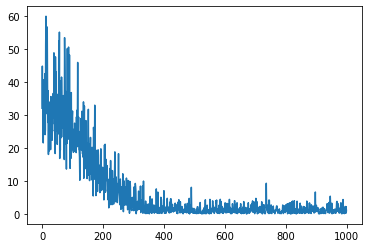

In [17]:
# 绘制训练误差
plt.plot(train_ls)
plt.show()

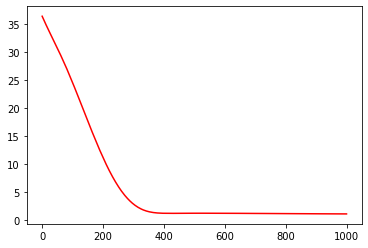

In [18]:
# 绘制测试误差
plt.plot(test_ls, c='r')
plt.show()

## 预测测试集并校验预测结果准确率

为了更专业地估计血糖预测值相较于参考值的临床准确值，1978年clark等人提出了克拉克误差网络分析(Clarke error grid analysis, EGA)方法，对血糖浓度检测方法进行估计。如今，该方法以广泛被认为是评估血糖浓度检测产品临床准确性的“金标准”。其中X轴和Y轴分别表示血糖浓度的参考值和预测值，即分别为真值和预测值，根据不同的准确性以及导致的临床后果的严重程度，克拉克误差网络分为A，B，C，D和E共5个区域。

区域A表示偏离参考值约20%或在低血糖范围内(<70mg/dl)的血糖浓度预测值，该该范围内的预测值是准确的，因此可以据此做出正确的临床治疗方案。区域B位于区域A的上方和下方，该区域的预测值偏离参考值超过20%，但只会导致良性治疗决策或无决策。落在A区域和B区域的预测值在临床上都是可以接受的，而落在区域C，D和E的预测值具有潜在的危险，并且有可能会导致重大的临床错误。因此，可以分别通过落在区域A，B，C，D和E中的样本数据的百分比来评估已建立的校准模型的性能。

In [19]:
# 获取预测结果，记住将tensor转换为numpy
predict_y = net(test_x).detach_().numpy()
predict_y[0:5]

array([[6.703916 ],
       [6.4691796],
       [6.7431455],
       [7.164813 ],
       [4.935549 ]], dtype=float32)

克拉克网络的函数参照师姐的matlab程序修改得到，或许可以简化其中的一些循环，不过确实有点麻烦，就没优化了。。。

In [21]:
# clarke网格误差分析
def clarke(y,y_predicted):
    """
    clarke网格分析

    total, percentage = clarke(y, yp)
    
    INPUTS:
    y       Reference values(血糖浓度参考值)
    yp      Predicted/estimated values(血糖预测值)
    
    OUTPUTS:
    total   A，B，C，D，E五个区域落入点的总数，为一个(5, 1)的np.array
    percentage  分别是五个区域落入点数占总数的百分比
    """
    # 设置坐标轴范围和坐标轴名称
    plt.xlim(0, 400*0.0556)
    plt.ylim(0, 400*0.0556)
    plt.xlabel('Reference values of Blood Glucose(mmol/L)')
    plt.ylabel('Predicted values of Blood Glucose(mmol/L)')
    # 获取数据长度
    n = len(y)
    # 散点图绘制数据
    plt.scatter(y, y_predicted, s=15)
    # 绘制网线
    # 上半区网线
    plt.plot([0,400*0.0556],[0,400*0.0556],linestyle=':',c='k') 
    plt.plot([0,175*0.0556/3],[70*0.0556,70*0.0556],c='k',linewidth=1)
    plt.plot([175*0.0556/3,400*0.0556/1.2],[70*0.0556,400*0.0556],c='k',linewidth=1)
    plt.plot([70*0.0556,70*0.0556],[84*0.0556,400*0.0556],c='k', linewidth=1)
    plt.plot([0,70*0.0556],[180*0.0556,180*0.0556],c='k',linewidth=1)
    plt.plot([70*0.0556,290*0.0556],[180*0.0556,400*0.0556],c='k', linewidth=1)
    # 下半区网线绘制
    plt.plot([70*0.0556,70*0.0556],[0,56*0.0556],c='k',linewidth=1)
    plt.plot([70*0.0556,400*0.0556],[56*0.0556,320*0.0556],c='k',linewidth=1)
    plt.plot([180*0.0556,180*0.0556],[0,70*0.0556],c='k',linewidth=1)
    plt.plot([180*0.0556,400*0.0556],[70*0.0556,70*0.0556],c='k',linewidth=1)
    plt.plot([240*0.0556,240*0.0556],[70*0.0556,180*0.0556],c='k',linewidth=1)
    plt.plot([240*0.0556,400*0.0556],[180*0.0556,180*0.0556],c='k',linewidth=1)
    plt.plot([130*0.0556,180*0.0556],[0,70*0.0556],c='k',linewidth=1)
    
    # 绘制区域标签A,B,C,D,E
    plt.text(30*0.0556,20*0.0556,'A',fontsize=9)
    plt.text(30*0.0556,150*0.0556,'D',fontsize=9)
    plt.text(30*0.0556,380*0.0556,'E',fontsize=9)
    plt.text(150*0.0556,380*0.0556,'C',fontsize=9)
    plt.text(160*0.0556,20*0.0556,'C',fontsize=9)
    plt.text(380*0.0556,20*0.0556,'E',fontsize=9)
    plt.text(380*0.0556,120*0.0556,'D',fontsize=9)
    plt.text(380*0.0556,260*0.0556,'B',fontsize=9)
    plt.text(280*0.0556,380*0.0556,'B',fontsize=9)

    # 计算数据
    total = np.zeros(5)
    # A区域
    for i in range(0,n):
        if (y[i] <= 70*0.0556 and y_predicted[i] <= 70*0.0556) or (y_predicted[i] <= 1.2*y[i] and y_predicted[i] >= 0.8*y[i]): 
            total[0] = total[0] + 1
        else:
            # E区域
            if(y[i] >= 180*0.0556 and y_predicted[i] <= 70*0.0556) or (y[i] <= 70*0.0556 and y_predicted[i] >= 180*0.0556):
                total[4] = total[4] + 1
            else:
                # 区域C
                if (y[i] >= 70*0.0556 and y[i] <= 290*0.0556) and (y_predicted[i] >= y[i] + 110*0.0556) or (y[i] >= 130*0.0556 and y[i] <= 180*0.0556) and (y_predicted[i] <= (7/5)*y[i] - 182*0.0556):
                    total[2] = total[2] + 1
                else:
                    # 区域D
                    if (y[i] >= 240*0.0556) and (y_predicted[i] >= 70*0.0556) and (y_predicted[i] <= 180*0.0556) or (y[i] <= 175*0.0556/3 and y_predicted[i] <= 180*0.0556) and (y_predicted[i] >= 70*0.0556) or (y[i] >= 175*0.0556/3 and y[i] <= 70*0.0556) and (y_predicted[i] >= (6/5)*y[i]):
                        total[3] = total[3] + 1
                    else:
                        # 区域B
                        total[1] = total[1] + 1

    percentage = (total/n)*100
    plt.show()
    return total, percentage

In [22]:
test_y = test_y.numpy()

In [23]:
test_y.size

82

In [24]:
predict_y.size

82

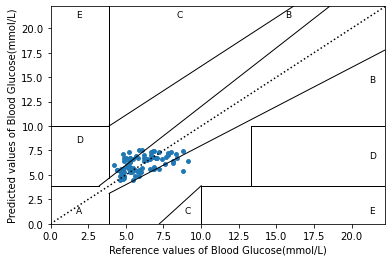

In [25]:
# 绘制克拉克误差网络
total, percentage = clarke(test_y, predict_y)

In [26]:
print(test_y[0:5])

[[5.3]
 [9.1]
 [5.8]
 [8.3]
 [5.9]]


In [27]:
print(predict_y[0:5])

[[6.703916 ]
 [6.4691796]
 [6.7431455]
 [7.164813 ]
 [4.935549 ]]


In [28]:
# 查看落入各区域的点数
total

array([60., 22.,  0.,  0.,  0.])

In [29]:
# 查看落入各区域点数的百分比
percentage

array([73.17073171, 26.82926829,  0.        ,  0.        ,  0.        ])

## 查看预测值与真实值的差别

那个克拉克误差网络看起来确实不太好看预测与真实值的差别，还是习惯直接看两个值之间的差别，将预测值减去真实值，并绘制一个柱状图，这样看起来就简单明了了

>plt.bar()绘图居然提示报错。。。将numpy.array转换为list才成功绘图。。。这个bug有点莫名其妙，暂时不清楚为啥，有知道的可以告诉我一下

In [32]:
# 将numpy.array转换为list，便于plt.bar画图
diff = (test_y - predict_y).tolist()
diff[0:5]

[[-1.4039158821105957],
 [2.6308207511901855],
 [-0.9431452751159668],
 [1.1351871490478516],
 [0.9644513130187988]]

In [33]:
import itertools
# 将嵌套的数组转换为一维的列表
diff = list(itertools.chain.from_iterable(diff))

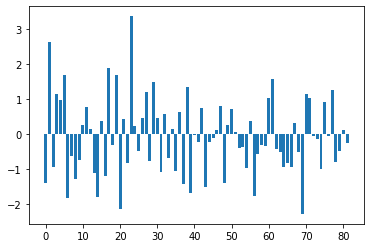

In [34]:
plt.bar(range(len(diff)), diff)
# plt.ylim(-10, 10)
plt.show()

这里基本上可以看到，预测值和真实值的差距真的是太大了。。。。血糖值正常在6左右，误差基本在1-3，甚至有3以上的

这里总结一下可以改进的地方吧：

* 决定血糖的可以加上其他的因素，例如测试者的年龄，体重，身高(或者BMI指数，胖的人多半血糖高)等，只要是可能和测试者血糖相关的都可以
* 模型的复杂度不够，相关的也意味着数据的特征维度不够
* 数据量不够，这里数据量只有205组，确实太少太少了
* 还有一点比较麻烦的是，人与人的体质是不同的，我曾在极度愤怒的情况下体重160，现在140。。。所以人与人是不同的，测试的模型可以分为单人单次的模型或是多人多次的模型，如果是多人多次测量的数据可能包含个人的误差，要保证准确度，需要考虑个体差异。。。
* 感觉喜欢渺茫，难搞。。。想放弃。